<a href="https://colab.research.google.com/github/7aslan/Diagnosis_Of_Pneumonia/blob/main/Diagnosis_Of_Pneumonia_Using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:02<00:00, 42.4MB/s]
100% 2.29G/2.29G [01:03<00:00, 39.1MB/s]


In [ ]:
#Unzip the downloaded data
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip","r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Lets look at that how many images are in each folder
import os
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'chest_xray'.
There are 2 directories and 0 images in 'chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/test/NORMAL'.
There are 1 directories and 1 images in 'chest_xray/__MACOSX'.
There are 3 directories and 3 images in 'chest_xray/__MACOSX/chest_xray'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/__MACOSX/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/__MACOSX/chest_xray/test/NORMAL'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/train'.
There are 0 directories and 3876 images in 'chest_xray/__MACOSX/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1342 images in 'chest_xray/__MACOSX/chest_xray/train/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/__MACOSX/chest_xray/val'.
There are 0 

We have lots of files in this dataset. But I am gonna focus on chest_xray files.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  target_folder= target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (1096, 1648)


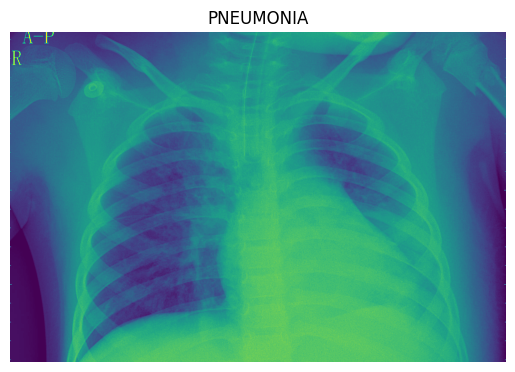

In [ ]:
img=view_random_image(target_dir="/content/chest_xray/chest_xray/train/", target_class="PNEUMONIA")

In [ ]:
img

array([[14, 14, 15, ..., 38, 39, 35],
       [14, 14, 15, ..., 40, 40, 37],
       [14, 15, 15, ..., 40, 41, 39],
       ...,
       [12,  9,  0, ...,  0,  0, 17],
       [ 7, 16, 16, ..., 14,  4,  2],
       [16,  0, 18, ..., 12,  4,  1]], dtype=uint8)

#Pre-processing Data
Lets prepare our dataset i am gonna use ImageDataGenerators class along with flow_from_directory method . I am planning to use data augmentation which will be compund on the Neural network architecture.

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
BATCH_SIZE = 32
IMG_SIZE =(256,256)
train_dir="/content/chest_xray/chest_xray/train"
test_dir="/content/chest_xray/chest_xray/test"
val_dir="/content/chest_xray/chest_xray/val"
train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         shuffle=True,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMG_SIZE)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

val_data = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                       shuffle=True,
                                                       batch_size=BATCH_SIZE,
                                                       image_size=IMG_SIZE)




Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


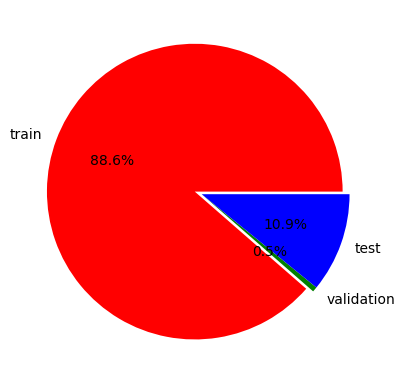

In [153]:
plt.pie([len(train_data), len(val_data), len(test_data)],
        labels=["train", "validation", "test"], autopct="%.1f%%", colors=["red", "green", "blue"],
        explode=(0.05,0,0))
plt.show()

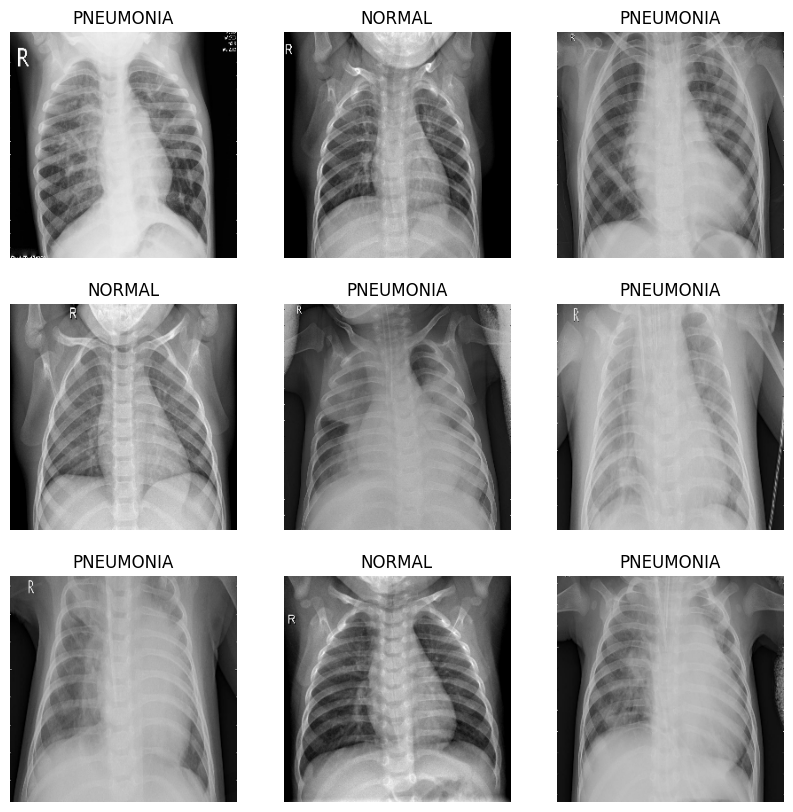

In [ ]:
class_names = train_data.class_names

plt.figure(figsize=(10,10))
for images , labels in train_data.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
vali_data = val_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),

])

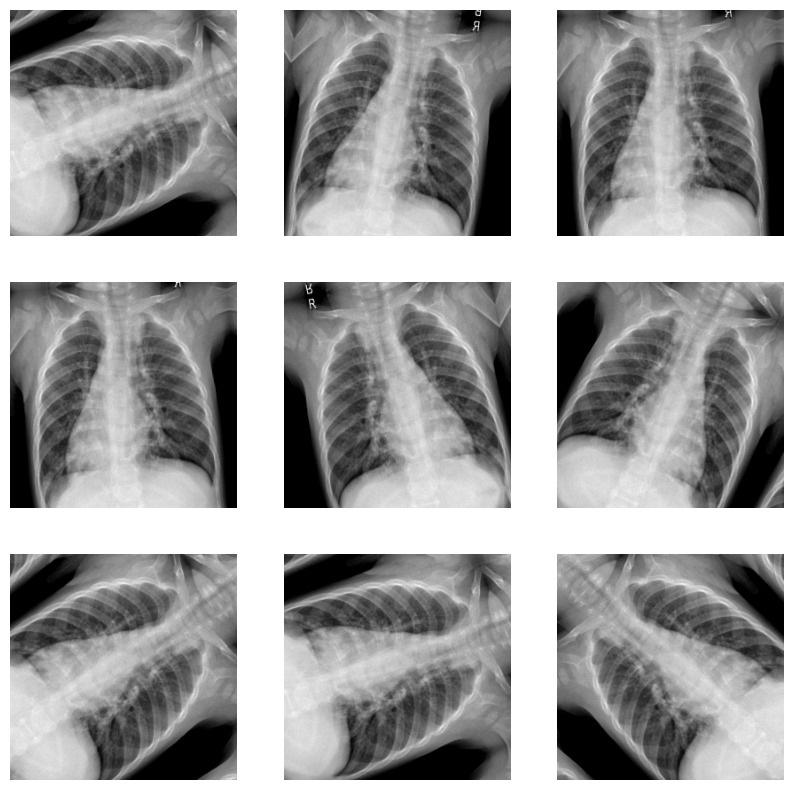

In [ ]:
for image, _ in train_data.take(1):
  plt.figure(figsize=(10,10))
  first_image=image[0]
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    augmented_image=data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255.)
    plt.axis("off")

In [ ]:
preprocess_input=tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale=tf.keras.layers.Rescaling(1/127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
image_batch , label_batch =next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable=False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 8, 8, 1)


In [ ]:
inputs = tf.keras.Input(shape=(256,256,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

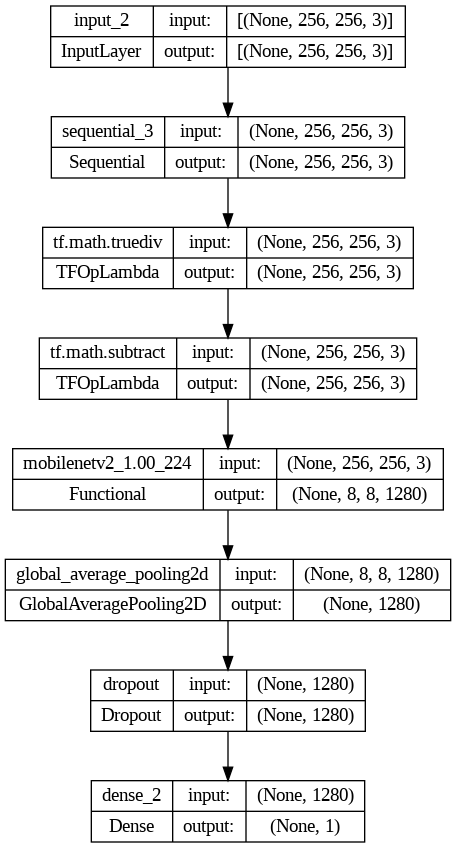

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
initial_epochs = 10
loss0 , accuracy0 = model.evaluate(val_data)

1/1 [==============================] - 4s 4s/step - loss: 7.9958 - accuracy: 0.2500


In [ ]:
print("Initial loss : {:.2f}".format(loss0))
print("Initial accuracy : {:.2f}".format(accuracy0))



Initial loss : 8.00
Initial accuracy : 0.25


In [ ]:
history = model.fit(train_data,
                    epochs = initial_epochs,
                    validation_data=val_data)

Epoch 1/10
163/163 [==============================] - 41s 199ms/step - loss: 2.0159 - accuracy: 0.7659 - val_loss: 1.5692 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 37s 221ms/step - loss: 2.4091 - accuracy: 0.7765 - val_loss: 2.8932 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 38s 225ms/step - loss: 0.8987 - accuracy: 0.8817 - val_loss: 0.2180 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 35s 204ms/step - loss: 0.8155 - accuracy: 0.8938 - val_loss: 1.1135 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 33s 196ms/step - loss: 0.7003 - accuracy: 0.9045 - val_loss: 0.2199 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 34s 203ms/step - loss: 1.0494 - accuracy: 0.8691 - val_loss: 2.2699 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 35s 206ms/step - loss: 1.2620 - accuracy: 0.8802 - val_loss: 6.7867 - val_ac

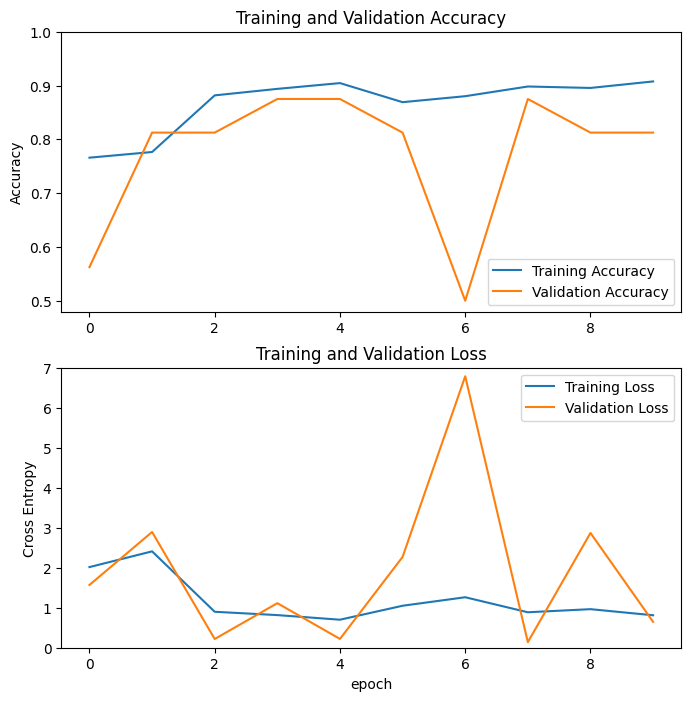

In [ ]:

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,7.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


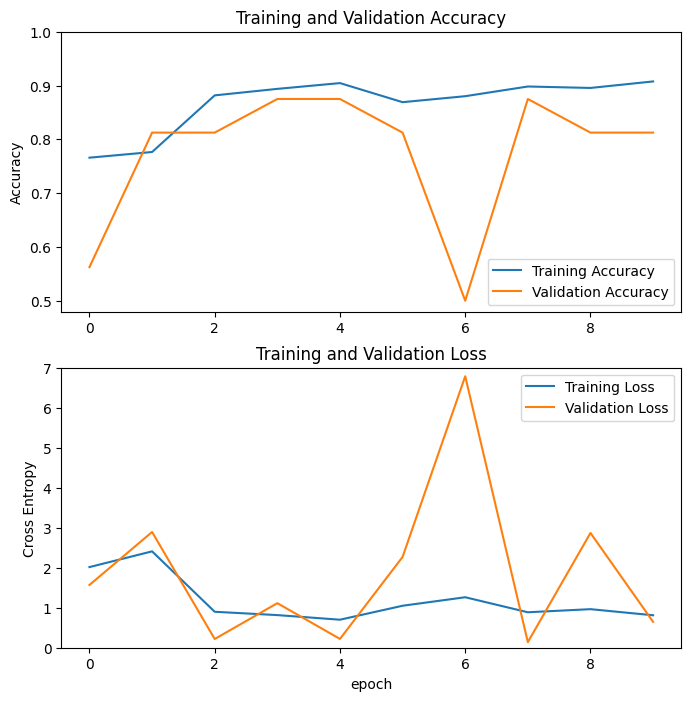

In [ ]:
plot_loss_curves(history)

In [ ]:
base_model.trainable=True

In [ ]:
print("Number of layers in the base model :", len(base_model.layers))

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

Number of layers in the base model : 154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name="accuracy")])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

148

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_data)

Epoch 10/20
163/163 [==============================] - 76s 267ms/step - loss: 2.1281 - accuracy: 0.6373 - val_loss: 0.4172 - val_accuracy: 0.8333
Epoch 11/20
163/163 [==============================] - 45s 267ms/step - loss: 0.5521 - accuracy: 0.8133 - val_loss: 0.5327 - val_accuracy: 0.8381
Epoch 12/20
163/163 [==============================] - 44s 259ms/step - loss: 0.4247 - accuracy: 0.8692 - val_loss: 0.5271 - val_accuracy: 0.8333
Epoch 13/20
163/163 [==============================] - 46s 269ms/step - loss: 0.3817 - accuracy: 0.8855 - val_loss: 0.4886 - val_accuracy: 0.8429
Epoch 14/20
163/163 [==============================] - 45s 266ms/step - loss: 0.3444 - accuracy: 0.9024 - val_loss: 0.5491 - val_accuracy: 0.8157
Epoch 15/20
163/163 [==============================] - 46s 266ms/step - loss: 0.2885 - accuracy: 0.9183 - val_loss: 0.4113 - val_accuracy: 0.8686
Epoch 16/20
163/163 [==============================] - 47s 279ms/step - loss: 0.2375 - accuracy: 0.9266 - val_loss: 0.4151 -

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


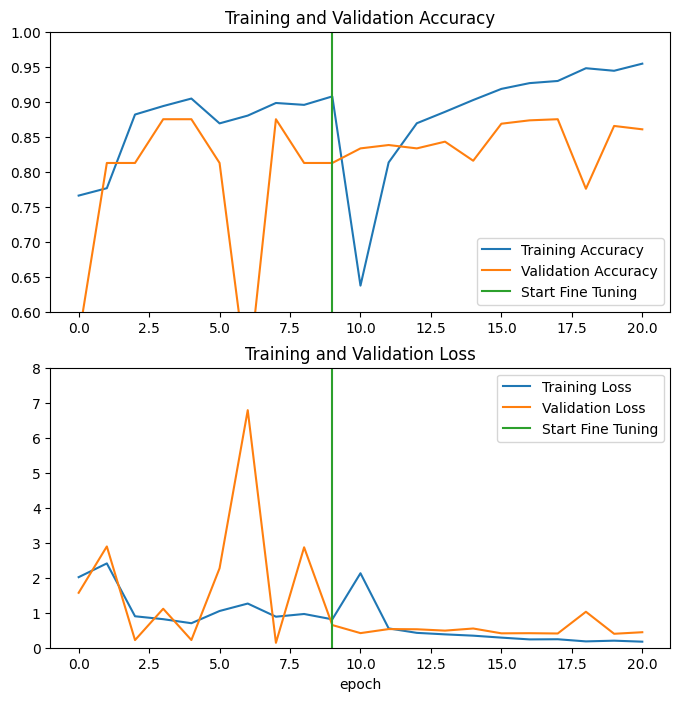

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 8.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)


20/20 [==============================] - 4s 111ms/step - loss: 0.4428 - accuracy: 0.8606
Test accuracy : 0.8605769276618958


Predictions:
 [1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1]


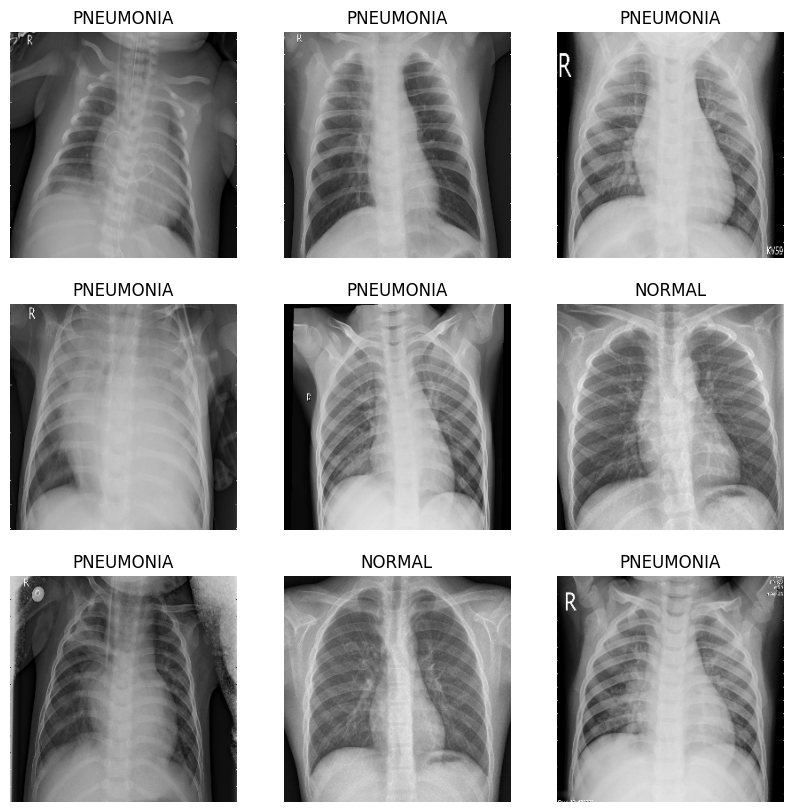

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


In [ ]:
model.save("pneumonia_fine_tune.h5")